# Predict all with 4o-mini

In [12]:
import pandas as pd

clustered_data_with_matched_addresses = pd.read_csv("../datasets/filtered_data_with_matched_addresses.csv")


filtered_data = (
    clustered_data_with_matched_addresses
    .sort_values(['caid', 'quarter', 'total_pings'], ascending=[True, True, False])
    .groupby(['caid', 'quarter'])
    .head(5)
    .copy()
)

filtered_data.shape

(158717, 34)

In [ ]:
import pandas as pd
import os
from dotenv import load_dotenv
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field, ValidationError

# Load API key
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")


model = ChatOpenAI(
    model_name="gpt-4o-mini",  # or "gpt-4o-mini" if officially supported
    temperature=0.0,
    api_key=""
)

# ----------------------------
# Define output schema
# ----------------------------
class MainClusterSelection(BaseModel):
    main_cluster: int = Field(description="Cluster number selected as main address")
    justification: str = Field(description="Why this cluster was selected")

parser = PydanticOutputParser(pydantic_object=MainClusterSelection)

# ----------------------------
# Prompt template
# ----------------------------
prompt = PromptTemplate(
    template="""
Each user (identified by a CAID) has multiple location clusters detected from mobile signals. Each cluster represents a place where the user spent time during the quarter.

Your task is to select the **main home address cluster** for the user based on the features below. We would like to differentiate from all other addresses, especially from work address.

A main address is usually:
- High **night** or **evening** consistency scores
- High consistency score
- High unique hours, meaning that the user is active at different times of the day
- High max consecutive hours, meaning that the user is active for a long time. 
- Long stays and broad time window coverage
- High dominance score
- High total pings and diverse hourly activity (entropy)

### Column Descriptions

cluster: Cluster index for this user 
consistency_score : % of days (from midnight to midnight) this cluster was seen
night_consistency_score: % of nights this cluster was seen (NaN if no night pings for the device during that quarter)  
evening_consistency_score: % of evenings this cluster was seen (NaN if no evening pings for the device during that quarter)  
day_consistency_score: % of daytime days (between 8am and 8pm)  this cluster was seen (NaN if no day pings for the device during that quarter)  
dominance_score: % of device pings in this cluster  
total_pings: Total number of pings in this cluster  
unique_hours: Number of unique hourly bins this cluster was active  
hour_entropy: Entropy of hourly activity (NaN if too few pings)  
max_consecutive_hours: It is the longest streak of consecutive hourly timestamps where a device was active only in one cluster, ignoring hours with no pings (silent hours).
time_window_coverage: Fraction of [day, evening, night] time windows with activity

---

### Cluster Candidates

{cluster_table}

Choose the main_cluster and explain why.

{format_instructions}
""",
    input_variables=["cluster_table"],
    partial_variables={"format_instructions": parser.get_format_instructions()}
)

chain = prompt | model | parser

# ----------------------------
# Format one CAID’s cluster group
# ----------------------------
def format_cluster_group(group):
    return "\n".join([
        f"cluster: {row['cluster']}, "
        f"consistency_score: {row['consistency_score']}, "
        f"night_consistency_score: {row['night_consistency_score']}, "
        f"evening_consistency_score: {row['evening_consistency_score']}, "
        f"day_consistency_score: {row['day_consistency_score']}, "
        f"dominance_score: {row['dominance_score']}, "
        f"total_pings: {row['total_pings']}, "
        f"unique_hours: {row['unique_hours']}, "
        f"hour_entropy: {row['hour_entropy']}, "
        f"max_consecutive_hours: {row['max_consecutive_hours']}, "
        f"time_window_coverage: {row['time_window_coverage']}"
        for _, row in group.iterrows()
    ])

# ----------------------------
# LLM call for one user
# ----------------------------
def decide_main_cluster(caid, group):
    try:
        table = format_cluster_group(group)
        output = chain.invoke({"cluster_table": table})
        return {
            "caid": caid,
            "quarter": group.iloc[0]["quarter"],
            "cluster": output.main_cluster,
            "is_main_address_4o_top5": 1,
            "main_address_justification_4o_top5": output.justification
        }
    except Exception as e:
        print(f"❌ Error for caid {caid}: {e}")
        return None

# ----------------------------
# Threaded 4o call for each CAID
# ----------------------------
results = []
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = {
        executor.submit(decide_main_cluster, caid, group): caid
        for (caid, quarter), group in filtered_data.groupby(["caid", "quarter"])
    }
    for future in tqdm(as_completed(futures), total=len(futures), desc="4p (Top 5)"):
        result = future.result()
        if result:
            results.append(result)

# ----------------------------
# Merge results and save
# ----------------------------
df_results = pd.DataFrame(results)
df = filtered_data.merge(df_results, on=["caid", "quarter", "cluster"], how="left")

df["is_main_address_4o_top5"] = df["is_main_address_4o_top5"].fillna(0).astype(int)
df["main_address_justification_4o_top5"] = df["main_address_justification_4o_top5"].fillna("")

df.to_csv("../datasets/filtered_data_with_main_address_per_user_4o_all.csv", index=False)
print("✅ Done. 4o predictions for top 5 clusters per CAID saved.")

4p (Top 5): 100%|██████████| 37986/37986 [3:14:36<00:00,  3.25it/s]  


✅ Done. 4o predictions for top 5 clusters per CAID saved.


In [14]:
filtered_data

,Unnamed: 0,caid,quarter,cluster,total_pings,unique_days,unique_hours,zipcode,centroid_latitude,centroid_longitude,...,total_weekday_days,weekend_days,weekday_days,weekend_focus_score,dominance_score,hour_entropy,max_consecutive_hours,median_income_household_2023,matches_known_address,matched_address
0,0,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,2,0,32,3,3,90020,34.065744,-118.296350,...,3.0,NaN,3.0,NaN,0.666667,0.900256,253,55832,1,"450 S. Kenmore Avenue #112, Los Angeles, CA, 9..."
1,1,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,2,1,9,1,1,90002,33.959281,-118.253437,...,3.0,1.0,NaN,NaN,0.187500,NaN,1,56158,0,NaN
2,2,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,2,2,7,1,1,91606,34.182663,-118.383647,...,3.0,NaN,1.0,NaN,0.145833,NaN,1,66884,0,NaN
3,3,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,5,0,106,2,12,90020,34.065744,-118.296350,...,3.0,NaN,2.0,NaN,0.946429,2.257982,87,55832,1,"450 S. Kenmore Avenue #112, Los Angeles, CA, 9..."
4,4,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,5,3,6,1,2,90020,34.065623,-118.292500,...,3.0,NaN,1.0,NaN,0.053571,0.450561,4,55832,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167338,1167338,fffc5273eff908ea2b2f0575cba9456bfb8a297f250d97...,5,8,1,1,1,90068,34.105830,-118.324080,...,4.0,1.0,NaN,NaN,0.011111,NaN,1,101720,0,NaN
1167339,1167339,fffc5273eff908ea2b2f0575cba9456bfb8a297f250d97...,8,0,6,3,3,90013,34.047980,-118.247367,...,1.0,2.0,1.0,0.666664,0.750000,1.011404,150,32848,1,"400 South Main Street #503, Los Angeles, CA, 9..."
1167340,1167340,fffc5273eff908ea2b2f0575cba9456bfb8a297f250d97...,8,7,1,1,1,90017,34.050070,-118.268740,...,1.0,1.0,NaN,NaN,0.125000,NaN,1,51317,0,NaN
1167341,1167341,fffc5273eff908ea2b2f0575cba9456bfb8a297f250d97...,8,8,1,1,1,90068,34.105830,-118.324080,...,1.0,1.0,NaN,NaN,0.125000,NaN,1,101720,0,NaN


In [15]:
df.to_excel("../datasets/filtered_data_with_main_address_per_user_4o_all.xlsx", index=False)

In [17]:
df

,Unnamed: 0,caid,quarter,cluster,total_pings,unique_days,unique_hours,zipcode,centroid_latitude,centroid_longitude,...,weekday_days,weekend_focus_score,dominance_score,hour_entropy,max_consecutive_hours,median_income_household_2023,matches_known_address,matched_address,is_main_address_4o_top5,main_address_justification_4o_top5
0,0,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,2,0,32,3,3,90020,34.065744,-118.296350,...,3.0,NaN,0.666667,0.900256,253,55832,1,"450 S. Kenmore Avenue #112, Los Angeles, CA, 9...",1,Cluster 0 is selected as the main home address...
1,1,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,2,1,9,1,1,90002,33.959281,-118.253437,...,NaN,NaN,0.187500,NaN,1,56158,0,NaN,0,
2,2,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,2,2,7,1,1,91606,34.182663,-118.383647,...,1.0,NaN,0.145833,NaN,1,66884,0,NaN,0,
3,3,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,5,0,106,2,12,90020,34.065744,-118.296350,...,2.0,NaN,0.946429,2.257982,87,55832,1,"450 S. Kenmore Avenue #112, Los Angeles, CA, 9...",1,Cluster 0 is selected as the main home address...
4,4,000c2d116598ea942c398285b59f0e8ee465d200810bfa...,5,3,6,1,2,90020,34.065623,-118.292500,...,1.0,NaN,0.053571,0.450561,4,55832,0,NaN,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158712,1167338,fffc5273eff908ea2b2f0575cba9456bfb8a297f250d97...,5,8,1,1,1,90068,34.105830,-118.324080,...,NaN,NaN,0.011111,NaN,1,101720,0,NaN,0,
158713,1167339,fffc5273eff908ea2b2f0575cba9456bfb8a297f250d97...,8,0,6,3,3,90013,34.047980,-118.247367,...,1.0,0.666664,0.750000,1.011404,150,32848,1,"400 South Main Street #503, Los Angeles, CA, 9...",1,Cluster 0 is selected as the main home address...
158714,1167340,fffc5273eff908ea2b2f0575cba9456bfb8a297f250d97...,8,7,1,1,1,90017,34.050070,-118.268740,...,NaN,NaN,0.125000,NaN,1,51317,0,NaN,0,
158715,1167341,fffc5273eff908ea2b2f0575cba9456bfb8a297f250d97...,8,8,1,1,1,90068,34.105830,-118.324080,...,NaN,NaN,0.125000,NaN,1,101720,0,NaN,0,


In [28]:
# Get all unique CAIDs in Q2 with at least one non-NaN matched_address
q2_valid_caids = df[(df["quarter"] == 2) & (df["matched_address"].notna())]["caid"].unique()

# Print the number of unique CAIDs
print("✅ Number of unique CAIDs with at least one non-NaN matched_address in Q2:", len(q2_valid_caids))


✅ Number of unique CAIDs with at least one non-NaN matched_address in Q2: 8680


In [29]:
# Get all unique CAIDs in Q2 with at least one non-NaN matched_address and is_main_address_4o_top5 == 1
q2_valid_caids_top5 = df[(df["quarter"] == 2) & 
                          (df["matched_address"].notna()) & 
                          (df["is_main_address_4o_top5"] == 1)]["caid"].unique()

# Print the number of unique CAIDs
print("✅ Number of unique CAIDs with at least one non-NaN matched_address and is_main_address_4o_top5 == 1 in Q2:", len(q2_valid_caids_top5))


✅ Number of unique CAIDs with at least one non-NaN matched_address and is_main_address_4o_top5 == 1 in Q2: 6513


# Histogram (with matched addresses)

In [37]:
df = pd.read_csv("../datasets/filtered_data_with_main_address_per_user_4o_all.csv")

/var/folders/k7/b0_b7t6j6n72t68sh4s7t8400000gn/T/ipykernel_39705/120671860.py:49: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/othmanbensouda/Desktop/mobile_data/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


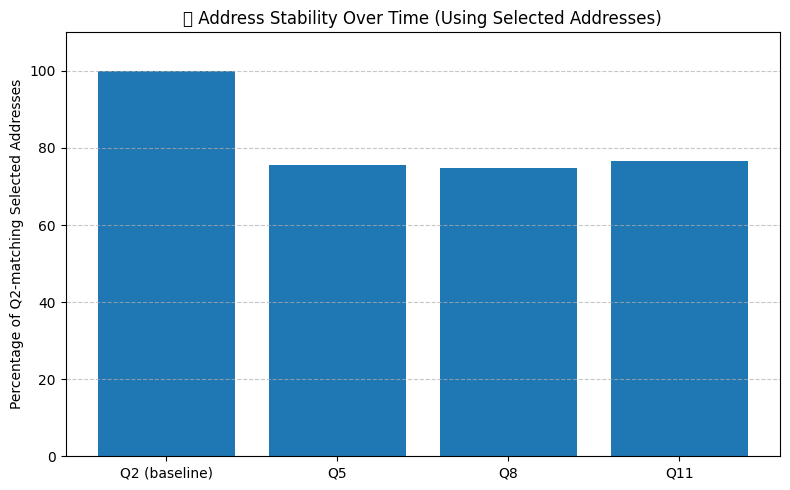

In [39]:
import pandas as pd
import matplotlib.pyplot as plt


# Step 1: Get baseline CAIDs with is_main_address_4o_top5 == 1 in Q2
baseline_caids = df[(df["quarter"] == 2) & (df["is_main_address_4o_top5"] == 1) & (df["matched_address"].notna())]["caid"].unique()
df_baseline = df[df["caid"].isin(baseline_caids)]

# Step 2: Get the selected addresses for each quarter (Q2, Q5, Q8, Q11)
def get_selected_address(df, quarter):
    return (
        df[(df["quarter"] == quarter) & (df["is_main_address_4o_top5"] == 1) & (df["matched_address"].notna())]
        .drop_duplicates("caid")[["caid", "matched_address"]]
        .rename(columns={"matched_address": f"q{quarter}_best_address"})
    )

q2 = get_selected_address(df_baseline, 2)
q5 = get_selected_address(df_baseline, 5)
q8 = get_selected_address(df_baseline, 8)
q11 = get_selected_address(df_baseline, 11)

# Step 3: Merge addresses across all quarters
merged = q2.merge(q5, on="caid", how="left") \
           .merge(q8, on="caid", how="left") \
           .merge(q11, on="caid", how="left")

# Step 4: Define fuzzy address match
def address_match(a, b, tolerance=0):
    if pd.isna(a) or pd.isna(b):
        return False
    return a.strip().lower()[:int(len(a) * tolerance)] in b.strip().lower() or \
           b.strip().lower()[:int(len(b) * tolerance)] in a.strip().lower()

# Calculate matching percentages for subsequent quarters
match_q5 = merged.apply(lambda row: address_match(row["q2_best_address"], row["q5_best_address"]), axis=1).mean() * 100
match_q8 = merged.apply(lambda row: address_match(row["q2_best_address"], row["q8_best_address"]), axis=1).mean() * 100
match_q11 = merged.apply(lambda row: address_match(row["q2_best_address"], row["q11_best_address"]), axis=1).mean() * 100

# Step 5: Plot bar chart
quarters = ["Q2 (baseline)", "Q5", "Q8", "Q11"]
percentages = [100, match_q5, match_q8, match_q11]

plt.figure(figsize=(8, 5))
plt.bar(quarters, percentages)
plt.ylim(0, 110)
plt.ylabel("Percentage of Q2-matching Selected Addresses")
plt.title("🏠 Address Stability Over Time (Using Selected Addresses)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


# Histogram (with clusters)

# Regenerate plot with clusters, not eviction addresses
# Digging into some cases between Q3-Q4 mismatch
# Look at placebo pattern. Sample same number of mobiles, try to get a similar distribution in terms total number of pings by device
# Generate the table for undergrads


/var/folders/k7/b0_b7t6j6n72t68sh4s7t8400000gn/T/ipykernel_39705/2487731397.py:44: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/othmanbensouda/Desktop/mobile_data/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


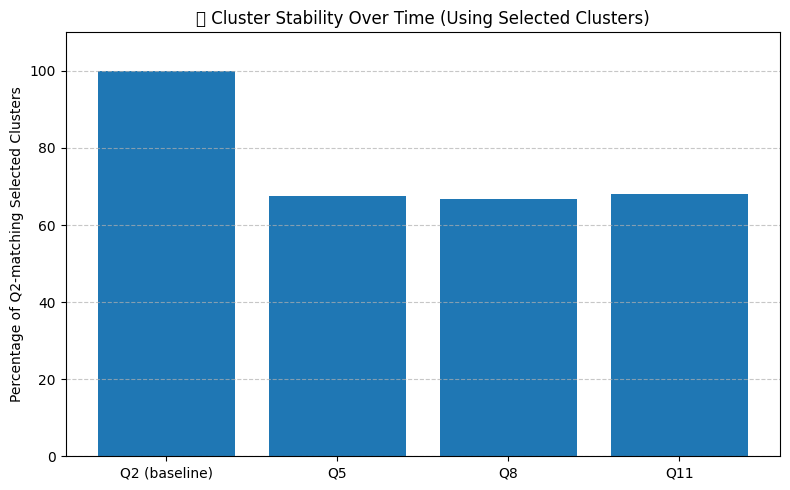

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Get baseline CAIDs with is_main_address_4o_top5 == 1 in Q2
baseline_caids = df[(df["quarter"] == 2) & (df["is_main_address_4o_top5"] == 1)]["caid"].unique()
df_baseline = df[df["caid"].isin(baseline_caids)]

# Step 2: Get selected clusters for each quarter (Q2, Q5, Q8, Q11)
def get_selected_cluster(df, quarter):
    return (
        df[(df["quarter"] == quarter) & (df["is_main_address_4o_top5"] == 1)]
        .drop_duplicates("caid")[["caid", "cluster"]]
        .rename(columns={"cluster": f"q{quarter}_best_cluster"})
    )

q2 = get_selected_cluster(df_baseline, 2)
q5 = get_selected_cluster(df_baseline, 5)
q8 = get_selected_cluster(df_baseline, 8)
q11 = get_selected_cluster(df_baseline, 11)

# Step 3: Merge clusters across all quarters
merged = q2.merge(q5, on="caid", how="left") \
           .merge(q8, on="caid", how="left") \
           .merge(q11, on="caid", how="left")

# Step 4: Calculate matching percentages
def cluster_match(a, b):
    return a == b if pd.notna(a) and pd.notna(b) else False

match_q5 = merged.apply(lambda row: cluster_match(row["q2_best_cluster"], row["q5_best_cluster"]), axis=1).mean() * 100
match_q8 = merged.apply(lambda row: cluster_match(row["q2_best_cluster"], row["q8_best_cluster"]), axis=1).mean() * 100
match_q11 = merged.apply(lambda row: cluster_match(row["q2_best_cluster"], row["q11_best_cluster"]), axis=1).mean() * 100

# Step 5: Plot bar chart
quarters = ["Q2 (baseline)", "Q5", "Q8", "Q11"]
percentages = [100, match_q5, match_q8, match_q11]

plt.figure(figsize=(8, 5))
plt.bar(quarters, percentages)
plt.ylim(0, 110)
plt.ylabel("Percentage of Q2-matching Selected Clusters")
plt.title("🏠 Cluster Stability Over Time (Using Selected Clusters)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [43]:
# Step 1: Create the merged cluster DataFrame (if not done already)
q2 = get_selected_cluster(df_baseline, 2)
q8 = get_selected_cluster(df_baseline, 8)
q11 = get_selected_cluster(df_baseline, 11)

merged = q2.merge(q8, on="caid", how="left") \
           .merge(q11, on="caid", how="left")

# Step 2: Filter where Q11 == Q2 but Q8 != Q2
condition = (
    (merged["q11_best_cluster"] == merged["q2_best_cluster"]) &
    (merged["q8_best_cluster"] != merged["q2_best_cluster"]) &
    (merged["q11_best_cluster"].notna()) &
    (merged["q8_best_cluster"].notna())
)

filtered = merged[condition]

# Display or export the result
print(f"🔍 Found {len(filtered)} CAIDs matching the condition.")
display(filtered.head())


🔍 Found 1141 CAIDs matching the condition.


,caid,q2_best_cluster,q8_best_cluster,q11_best_cluster
4,001c7131fdba42373b7de1c7c425f2fe0d7dec70346158...,1,2.0,1.0
15,004d80664b879f7ad5c65f8141bfad2d6d7ec9548b6e2e...,0,2.0,0.0
17,005642d7e26db0ec641d4d4df4fdb162cacd2861114f78...,1,0.0,1.0
40,00df5286dd679474252937f9c072480a944ba74f6b6908...,6,4.0,6.0
43,00e8cecad02a9884ab444e7d880cdc527f5dff251f4cf5...,0,29.0,0.0


In [47]:
# Step 1: Create lookup tables for Q8 and Q11 clusters
q8_clusters = merged[["caid", "q8_best_cluster"]]
q11_clusters = merged[["caid", "q11_best_cluster"]]

# Step 2: Merge those cluster values into df_filtered_by_caid
df_annotated = df_filtered_by_caid.merge(q8_clusters, on="caid", how="left")
df_annotated = df_annotated.merge(q11_clusters, on="caid", how="left")

# Step 3 (optional): Rename columns if you want cleaner names
df_annotated.rename(columns={
    "q8_best_cluster": "cluster_chosen_in_q8",
    "q11_best_cluster": "cluster_chosen_in_q11"
}, inplace=True)

# Preview the result
print(f"📝 Annotated rows: {len(df_annotated)}")
display(df_annotated)



📝 Annotated rows: 19877


,Unnamed: 0,caid,quarter,cluster,total_pings,unique_days,unique_hours,zipcode,centroid_latitude,centroid_longitude,...,dominance_score,hour_entropy,max_consecutive_hours,median_income_household_2023,matches_known_address,matched_address,is_main_address_4o_top5,main_address_justification_4o_top5,cluster_chosen_in_q8,cluster_chosen_in_q11
0,194,001c7131fdba42373b7de1c7c425f2fe0d7dec70346158...,2,1,73,3,8,90065,34.092418,-118.210532,...,0.401099,1.776294,7,92903,0,NaN,1,Cluster 1 was selected as the main home addres...,2.0,1.0
1,193,001c7131fdba42373b7de1c7c425f2fe0d7dec70346158...,2,0,27,3,5,90014,34.043363,-118.250626,...,0.148352,1.526112,4,33822,0,NaN,0,NaN,2.0,1.0
2,197,001c7131fdba42373b7de1c7c425f2fe0d7dec70346158...,2,4,9,1,1,90013,34.045141,-118.248540,...,0.049451,NaN,1,32848,0,NaN,0,NaN,2.0,1.0
3,213,001c7131fdba42373b7de1c7c425f2fe0d7dec70346158...,2,20,9,1,2,90014,34.043982,-118.251215,...,0.049451,0.636514,1,33822,1,"111 West 7th Street, 614, Los Angeles, CA, 90014",0,NaN,2.0,1.0
4,210,001c7131fdba42373b7de1c7c425f2fe0d7dec70346158...,2,17,8,2,2,90012,34.057633,-118.236751,...,0.043956,0.562335,1,67635,1,"880 N ALAMEDA ST. APT #316W, LOS ANGELES, CA, ...",0,NaN,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19872,1167079,ffea2ef19c600a528208242926de66fffe71a0497dd04c...,11,0,192,3,16,91355,34.431167,-118.559959,...,0.860987,2.630622,207,109348,1,"24170 Newhall Ranch Road #10207, Santa Clarita...",1,Cluster 0 was selected as the main home addres...,3.0,0.0
19873,1167086,ffea2ef19c600a528208242926de66fffe71a0497dd04c...,11,13,5,1,1,91355,34.416935,-118.557891,...,0.022422,NaN,1,109348,0,NaN,0,NaN,3.0,0.0
19874,1167083,ffea2ef19c600a528208242926de66fffe71a0497dd04c...,11,5,4,1,1,91354,34.447732,-118.556393,...,0.017937,NaN,1,148818,0,NaN,0,NaN,3.0,0.0
19875,1167088,ffea2ef19c600a528208242926de66fffe71a0497dd04c...,11,15,4,1,1,93550,34.593542,-118.112835,...,0.017937,NaN,1,63811,0,NaN,0,NaN,3.0,0.0


In [49]:
df_annotated.to_excel("../datasets/q8_q11_clusters_annotated.xlsx", index=False)